In [3]:
from Bio import SeqIO
from tqdm.notebook import tqdm
from collections import defaultdict

from utils.experiment_utils import get_all_experiments_info, load_checkpoint#load_best_model
import torch
import os
import hydra
from omegaconf import DictConfig, OmegaConf
from torch.utils.data import DataLoader

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from datasets.virus import ViralDataset

from transformers import AutoTokenizer, AutoModel

In [4]:
device = 'cuda'
configs = get_all_experiments_info('outputs/', False)
cfg = [c for c in configs if 'virus' in c['name'] 
       and c['config']['training']['save_interval']==1]
cfg = cfg[0]
cfg

{'name': 'virus_da886fbe257e4684d43aa62ef4383e11',
 'dir': 'outputs/virus_da886fbe257e4684d43aa62ef4383e11',
 'config': {'dataset': {'_target_': 'datasets.virus.ViralDataset', 'data_dir': '/orcd/data/omarabu/001/gokul/DistributionEmbeddings/data/spikeprot0430', 'set_size': 16, 'max_length': '${experiment.max_length}', 'esm_name': '${experiment.esm_model_name}', 'progen_name': '${experiment.progen2_model_name}', 'lines_to_read': 100000000, 'max_sets_per_fam': 100, 'tokenize': '${experiment.tokenize}', 'seed': '${seed}'}, 'encoder': {'_target_': 'encoder.protein_encoders.ProteinSetEncoder', 'esm_model_name': '${experiment.esm_model_name}', 'latent_dim': '${experiment.latent_dim}', 'hidden_dim': '${experiment.hidden_dim}', 'pooling': 'mean', 'freeze': False, 'dist_type': 'tx', 'layers': 2, 'heads': 4}, 'model': {'_target_': 'types.NoneType'}, 'generator': {'_target_': 'generator.protein_generator.Progen2Generator', 'progen2_name': '${experiment.progen2_model_name}', 'latent_dim': '${exper

In [5]:
def load_model(cfg, path, device):
    enc = hydra.utils.instantiate(cfg['encoder'])
    gen = hydra.utils.instantiate(cfg['generator'])
    state = load_checkpoint(path, 5)
    enc.load_state_dict(state['encoder_state_dict'])
    gen.model.load_state_dict(state['generator_state_dict'])
    enc.eval()
    gen.model.eval()
    enc.to(device)
    gen.model.to(device)
    return enc, gen

In [16]:
dataset = hydra.utils.instantiate(cfg['config']['dataset'])
enc, gen = load_model(cfg['config'], cfg['dir'], 'cuda')
# collated = recursive_collate([dataset.__getitem__(i) for i in range(3)])

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
dataloader = DataLoader(dataset, batch_size=1)

In [47]:
for i, batch in enumerate(dataloader):
    samples = batch['samples']
    for k, v in samples.items():
        if isinstance(v, torch.Tensor):
            samples[k] = v.to('cuda')

    with torch.no_grad():
        latent = enc(samples)
        generated = gen.sample(latent, num_samples=5, return_texts=True)

        print(batch['time-loc'])
        break

['2019-12-China']


In [45]:
generated[1]

[['MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTTGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLI

<Axes: >

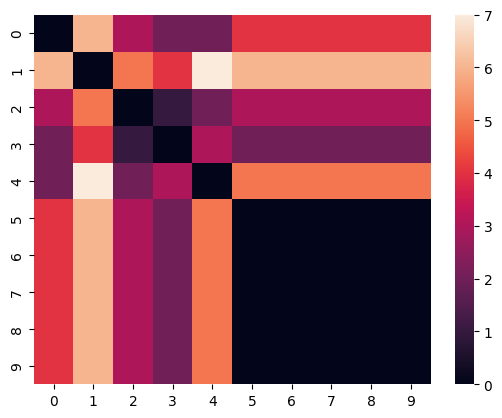

In [46]:
def levenshtein(a, b):
    dp = [[i + j if i * j == 0 else 0 for j in range(len(b) + 1)] for i in range(len(a) + 1)]
    for i in range(1, len(a) + 1):
        for j in range(1, len(b) + 1):
            dp[i][j] = min(
                dp[i-1][j] + 1,
                dp[i][j-1] + 1,
                dp[i-1][j-1] + (a[i-1] != b[j-1])
            )
    return dp[-1][-1]

strings = generated[1][0] + [x[0] for x in batch['raw_texts']][:5]
n = len(strings)
mat = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        mat[i, j] = levenshtein(strings[i], strings[j])

# plot heatmap!
sns.heatmap(mat)

In [33]:
for i in range(len(strings[2])):

    if strings[2][i] != strings[4][i]:
        print('Residue %d: %s, %s'%(i, strings[2][i], strings[4][i]))

Residue 156: F, L
Residue 438: K, N
Residue 476: N, S
Residue 483: K, E
Residue 541: N, Q
Residue 674: Q, H
Residue 768: V, G
Residue 844: A, S
Residue 938: F, S


False

In [18]:
# # load tiny esm2 model
# tok = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
# mdl = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D").cuda()

In [ ]:
# Zs = []

# TLs = []

# for i, batch in tqdm(enumerate(dataloader)):
#     samples = batch['samples']
#     for k, v in samples.items():
#         if isinstance(v, torch.Tensor):
#             samples[k] = v.to('cuda')

#     with torch.no_grad():
#         latent = mdl(samples['esm_input_ids'][0],
#                      samples['esm_attention_mask'][0]).last_hidden_state.mean(axis=(0,1))
    
#     Zs.append(latent.cpu().numpy())
#     TLs.append(batch['time-loc'])

0it [00:00, ?it/s]

In [ ]:
# Z = np.vstack(Zs)
# T = [t[0] for t in TLs]

In [ ]:
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

In [ ]:
# pca = PCA(n_components=50, svd_solver='full')
# tsne = TSNE(random_state=0)

# pcs = pca.fit_transform(Z)

In [ ]:
# tsnes = tsne.fit_transform(pcs)

In [ ]:
# months = [t[:7] for t in T]
# locs = [t[8:] for t in T]
# print(months[:3])
# print(locs[:3])

['2019-12', '2020-12', '2021-01']
['China', 'Philippines', 'Belgium']


In [48]:
# from matplotlib.colors import Normalize
# from matplotlib.cm import ScalarMappable
# from datetime import datetime

# # try parsing months safely to datetime
# dates = []
# for m in months:
#     try:
#         d = datetime.strptime(m, "%Y-%m")
#         dates.append(d)
#     except ValueError:
#         # skip or use a default? up to you!
#         dates.append(None)

# # drop None entries (or filter tsnes too if needed!)
# valid = [i for i, d in enumerate(dates) if d is not None]
# tsnes_valid = tsnes[valid]
# dates_valid = [dates[i] for i in valid]

# # map to numeric time (e.g. months since min)
# min_date = min(dates_valid)
# month_nums = np.array([(d.year - min_date.year) * 12 + d.month - min_date.month for d in dates_valid])

# # now plot like before!
# norm = Normalize(vmin=month_nums.min(), vmax=month_nums.max())
# cmap = plt.get_cmap("viridis")

# fig, ax = plt.subplots(figsize=(4, 3), dpi=300)

# # scatter with explicit ax
# sns.scatterplot(x=tsnes_valid[:, 0],
#                 y=tsnes_valid[:, 1],
#                 hue=month_nums,
#                 palette=cmap,
#                 hue_norm=norm,
#                 s=3,
#                 legend=False,
#                 ax=ax,)

# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_xlabel('TSNE1')
# ax.set_ylabel('TSNE2')

# # make the ScalarMappable manually
# sm = ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])

# # pass ax to colorbar so it knows where to go :)
# cbar = plt.colorbar(sm, ax=ax)
# cbar.set_label("months since 2019-12")

# plt.show()

